## Demo on the fusion of MCD43 and Sentinel 2

### UCL

#### Feng Yin

In this reposery, I will demonstrate the way how to connnect the MCD43 and Sentinel 2 data, with a high correaltion between the correpsonding band 12 between senitnel 2 and MCD43 adjusted to Sentinel 2 viewing angle as an indication.

In [2]:
import sys
sys.path.insert(0, 'python')
from spatial_mapping import *
from spectral_mapping import *
from datetime import datetime
import gdal
from glob import glob
from get_aeronet import *
import numpy as np
from mgrspy import mgrs as mg
from functools import partial
import multiprocessing
from get_brdf import *
from read_s2_meta import *
import scipy
import numpy.ma as ma
from query_landsat import *


from matplotlib import gridspec,cm, colors
import pylab as plt
%matplotlib inline

Loading in the Aeronet sites having measurements over each month, and the correpsonding S2 file.

In [ ]:
# cross check with the landsat 8
s2_files = np.loadtxt('data/s2_files.txt', dtype=str)
rets = []
for site, lat, lon, s2_dir in s2_files:
    date = '-'.join(s2_dir.split('/')[-5:-2])
    y_m_d = datetime.strptime(date, '%Y-%m-%d')
    ret = que_land(lat=lat, lon=lon, start='%04d-%02d-%02d'%(y_m_d.year, y_m_d.month, y_m_d.day),\
                   end='%04d-%02d-%02d'%(y_m_d.year, y_m_d.month, y_m_d.day), maxc=10, minc=0)
    if ret['total'] >0:
        for i in ret['results']:
            print site, lat, lon, s2_dir, i['path'],i['row'] , i['LANDSAT_PRODUCT_ID']
            rets.append([site, lat, lon, s2_dir,i['sceneID'], i['LANDSAT_PRODUCT_ID']])

In [139]:
np.savetxt('aero_s2_l8.txt',rets, fmt='%s')

In [142]:
!head aero_s2_l8.txt

Alta_Floresta -9.871339 -56.104453 /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/7/31/0/ LC82270672016213LGN01
Tucson 32.233002 -110.953003 /home/ucfafyi/DATA/S2_MODIS/s_data/12/S/WA/2016/1/11/0/ LC80360372016011LGN01
Tucson 32.233002 -110.953003 /home/ucfafyi/DATA/S2_MODIS/s_data/12/S/WA/2016/1/11/0/ LC80360382016011LGN01
Tucson 32.233002 -110.953003 /home/ucfafyi/DATA/S2_MODIS/s_data/12/S/WA/2016/6/19/0/ LC80360382016171LGN01
Tucson 32.233002 -110.953003 /home/ucfafyi/DATA/S2_MODIS/s_data/12/S/WA/2016/6/19/0/ LC80360372016171LGN01
GSFC 38.9925 -76.839833 /home/ucfafyi/DATA/S2_MODIS/s_data/18/S/UJ/2016/11/7/0/ LC80150332016312LGN01
Wallops 37.941666 -75.474998 /home/ucfafyi/DATA/S2_MODIS/s_data/18/S/VG/2016/2/18/0/ LC80140342016049LGN01
Wallops 37.941666 -75.474998 /home/ucfafyi/DATA/S2_MODIS/s_data/18/S/VG/2016/2/18/0/ LC80140332016049LGN01
Sevilleta 34.354721 -106.885002 /home/ucfafyi/DATA/S2_MODIS/s_data/13/S/CU/2016/4/27/0/ LC80330362016118LGN01
Sevilleta 34.354721 -106.885002 /

In [149]:
rets = np.loadtxt('aero_s2_l8.txt', dtype=str)

In [70]:
s2_dir = '/home/ucfafyi/DATA/S2_MODIS/s_data/48/T/VP/2016/11/4/0/'
cloud = gdal.Open(s2_dir+'cloud.tiff').ReadAsArray()

In [62]:
g = gdal.Open(s2_dir+'B04.jp2')
driver = gdal.GetDriverByName('GTiff')
g1 = driver.Create(s2_dir+'cloud.tiff', g.RasterXSize, g.RasterYSize, 1, gdal.GDT_Byte)

projection   = g.GetProjection()
geotransform = g.GetGeoTransform()
g1.SetGeoTransform( geotransform )
g1.SetProjection( projection )
gcp_count = g.GetGCPs()
if gcp_count != 0:
    g1.SetGCPs( gcp_count, g.GetGCPProjection() )
g1.GetRasterBand(1).WriteArray(cloud)
g1=None; g=None

We can read in the correponding Aeronet measurements when the S2 passing by, using the metadata from S2 snesing time.

Alta_Floresta (-9.871339, -56.104453) ('2016-3-23', '/home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/3/23/0/') (12, 9, 83, '/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016083.h12v09.006.2016179155414.hdf')
Second order =  0.0607902469924
First order =  0.0628769961354


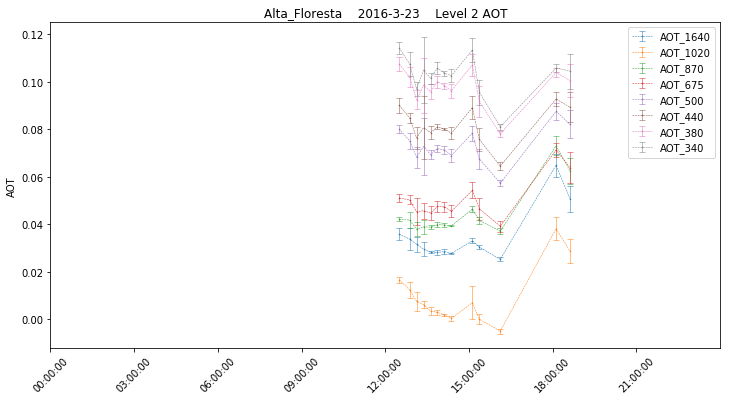

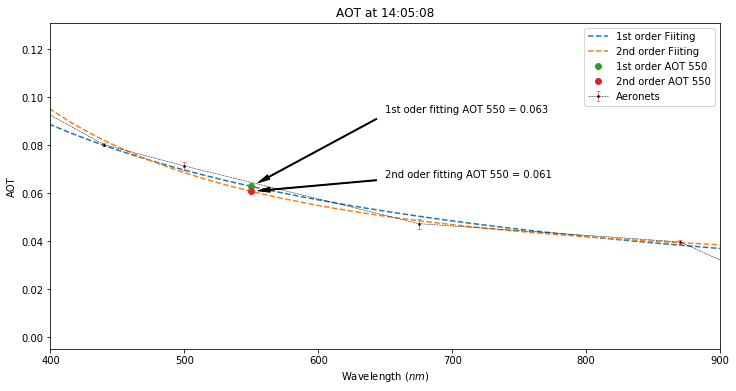

In [87]:
aero_root = '/home/ucfafyi/Downloads/AOT/LEV20/ALL_POINTS/'
root = '/home/ucfafyi/DATA/S2_MODIS/'
m_dir = root + 'm_data/'
for site, lat, lon, s2_dir in s2_files:

    date = '-'.join(s2_dir.split('/')[-5:-2])
    h,v = mtile_cal(float(lat), float(lon))
    y_m_d = datetime.strptime(date, '%Y-%m-%d')
    doy = y_m_d.timetuple().tm_yday
    m_file = glob(m_dir+'MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(y_m_d.year, doy,h,v))
    print site, (float(lat), float(lon)), (date, s2_dir), (h, v, doy,  m_file[0])
    with open(s2_dir+'tileInfo.json', 'rb') as f:
        for line in f:
            if 'timestamp' in line:
                h,m,s =  line.split('T')[-1].split('Z')[0].split(':')
                time = float(h)+ float(m)/60.+float(s)/3600.
    s,f = Aeronet_measures(site, date, time, root=aero_root, plot_all=1)
    plt.xlim(400, 900)
    print 'Second order = ', s[0]
    print 'First order = ',f[0]
    break

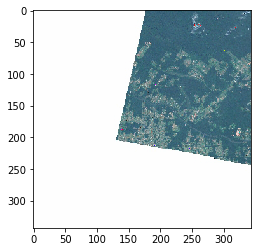

In [5]:
# a preview image of this tile
plt.imshow(gdal.Open(s2_dir+'preview.jpg').ReadAsArray().transpose(1,2,0)*2)

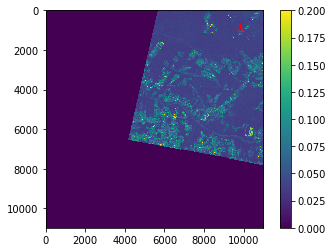

In [6]:
# from aeronet coordinate to sentinel 2
# mgrs coordinates and plot it in the image
aero_mg = mg.toMgrs(float(lat), float(lon), precision=4)
aero_mg_y, aero_mg_x = int(aero_mg[-8:-4]), int(aero_mg[-4:])
g = gdal.Open(s2_dir+'B04.jp2')
plt.imshow(g.ReadAsArray()*0.0001, vmin=0, vmax=0.2)
plt.plot(aero_mg_y, aero_mg_x, 'r2', ms=10) # aeronet site
plt.colorbar()

In [7]:
def gdal_read(fname, patch = None):
    '''
    a function for the reading of sentinel 2 files
    if the image is not 10980 * 10980
    then the patch will be shrink with
    correpsonding propotion, i.e. 2,6 
    for 20 meters and 60 meters resolution
    '''
    g = gdal.Open(fname)
    if g is None:
        raise IOError
    else:
        if patch == None:
            return g.ReadAsArray()
        else:
            if (g.RasterXSize,g.RasterYSize) == (5490, 5490):
                xoff, yoff, xsize, ysize = np.array(patch)/2
                return g.ReadAsArray(xoff, yoff, xsize, ysize)
            if (g.RasterXSize,g.RasterYSize) == (1830, 1830):
                xoff, yoff, xsize, ysize = np.array(patch)/6
                return g.ReadAsArray(xoff, yoff, xsize, ysize)
            else:
                xoff, yoff, xsize, ysize = patch
                return g.ReadAsArray(xoff, yoff, xsize, ysize)

In [8]:
# Since a large part of the image is empty
# so we only read in a pathch
# parallel read in the images 
# speeding up
pa = 5000, 0, 5000, 5000
bands = 'B02', 'B03', 'B04', 'B08', 'B11', 'B12', 'B8A'
fnames = [s2_dir+band_str+'.jp2' for band_str in bands]
pool = multiprocessing.Pool(processes=len(bands))
ret = pool.map(partial(gdal_read, patch=pa), fnames)

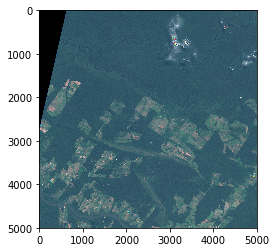

In [9]:
# cloud in the scene
plt.imshow(np.array([ret[2],ret[1],ret[0]]).transpose(1,2,0)*0.0005)

In [10]:
# call the s2 classification algorithm
# to get the cloud
img = dict(zip(bands,ret))
from cloud import classification
cl = classification(img = img)
cl.Get_cm_p()

Image classfication...
7%

python/cloud2.py:92: RuntimeWarning: divide by zero encountered in divide



14%
21%
29%
36%


python/cloud2.py:111: RuntimeWarning: divide by zero encountered in divide


43%
50%


python/cloud2.py:137: RuntimeWarning: divide by zero encountered in divide


57%


python/cloud2.py:143: RuntimeWarning: divide by zero encountered in divide


64%


python/cloud2.py:149: RuntimeWarning: divide by zero encountered in divide


71%
79%


python/cloud2.py:165: RuntimeWarning: divide by zero encountered in divide


86%


python/cloud2.py:176: RuntimeWarning: divide by zero encountered in divide


93%


python/cloud2.py:184: RuntimeWarning: divide by zero encountered in divide


99%
Done!!!


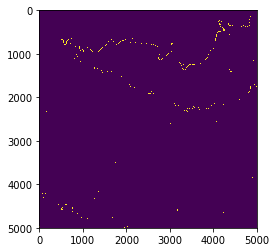

In [11]:
# the cloud mask dose not 
# find the cloud, so the 
# cloud screaning method should 
# be improved...
plt.imshow(cl.cm) 

the s2 cloud calssification failed for the detection of cloud... and classified the water as clouds...

In [176]:
# call the funtion to find the 
# corresponding pixels between S2 and MODIS tile
s2_fname = s2_dir+'B04.jp2'
tiles = Find_corresponding_pixels(s2_fname, destination_res=500)
print 'There are %d MODIS tiles covered by this high resolution image.'%len(tiles), '\n', 'Thay are %s and %s'%(tiles.keys()[0],tiles.keys()[1])

There are 2 MODIS tiles covered by this high resolution image. 
Thay are h21v05 and h20v05


Since our Aeronet is within h12v09 tile, so we only use h12v09.

We read in the sentinel 2 scanning geometry and put it into brdf kernels, to simulate the surface reflectance at 500 meter resolution when s2 passing by.

In [177]:
meta = readxml('%smetadata.xml'%s2_dir)
b_ind = [1,2,3,7,8,11,12]
vaa, vza = meta['mVa'][b_ind], meta['mVz'][b_ind]
sza = np.zeros(7)
sza[:] = meta['mSz']
saa = sza.copy()
saa[:] = meta['mSa']

In [180]:
H_inds, L_inds = tiles['h21v05']

In [15]:
brdf, qa = get_brdf_six(m_file[0], (sza, vza, vaa-saa),
                        bands=[1,2,3,4,5,6,7], flag=None, Linds= list(L_inds))           

In [16]:
# here we read in the whole image instead of a patch....
bands = 'B02', 'B03', 'B04', 'B08', 'B11', 'B12', 'B8A'
fnames = [s2_dir+band_str+'.jp2' for band_str in bands]
pool = multiprocessing.Pool(processes=len(bands))
ret = pool.map(partial(gdal_read, patch=None), fnames)
img = dict(zip(bands,ret))

In [17]:
from sklearn import linear_model
from scipy.stats import linregress
# a fucntion do the ransac for the linear regresion
def ransaclin(x,y, residual_threshold=0.2):
    y, x = y.reshape((len(y),1)), x.reshape((len(x),1))
    model_ransac = linear_model.RANSACRegressor(max_trials=10000000,\
                                                residual_threshold=residual_threshold)
    model_ransac.fit(x, y)
    inlier_mask = model_ransac.inlier_mask_
    return x[inlier_mask], y[inlier_mask], inlier_mask

In [18]:
b12 = ScaleExtent(img['B12'], (10980, 10980))
b12[0,:]=b12[-1,:]=b12[:,0]=b12[:,-1]=0 # deal with the border when convolution happened
s_b12 = b12[H_inds[0], H_inds[1]]
m_b12 = brdf[6]

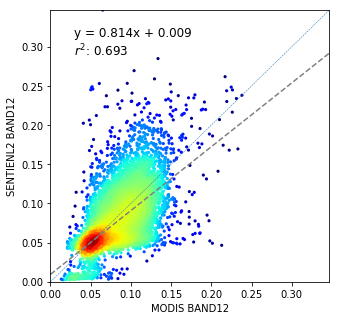

In [27]:
x,y = m_b12[s_b12>0], s_b12[s_b12>0]*0.0001
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
cmap = plt.cm.jet
mval = np.nanmax([x,y])
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)
slope,inter, rval, pval, std = scipy.stats.linregress(x, y)
if inter<0:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' - %.03f \n'%(-inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
else:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)

ax.scatter(x,y, c=kde, marker='o', s=10, edgecolor='',\
       norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
ax.set_xlim(0, mval)
ax.set_ylim(0, mval)
plt.xlabel('MODIS BAND12')
plt.ylabel('SENTIENL2 BAND12')

We simply using the corresponding pixels to do a linear regression, and the results are really bad, and the density regression graph is very scattered. However, we still can see most of the values are pretty much gathered together, so it indicates that this is due to the higher S2 spatial resolution hence higher contrast compared to the MODIS pixel. So we use the PSF model to simulate the coarse resolution Sentinel 2 measurements.

#### Spatial mapping

In [28]:
# we apply a PSF model to the S2 image
xstd, ystd = 40,40
ker = gaussian(xstd, ystd, 0)
conved = signal.fftconvolve(b12, ker, mode='same')
size = 2*int(round(max(1.96*xstd, 1.96*ystd))) # for the dialation
b12[0,:]=b12[-1,:]=b12[:,0]=b12[:,-1]=0 # deal with border issue
cloud =False # bad cloud algorithm...
dila_cloud = cloud_dilation( (b12 == 0)|cloud, iteration=size/2) # since the convolution will have cloud and border issue
b12_conved = ma.array(conved, mask=dila_cloud)

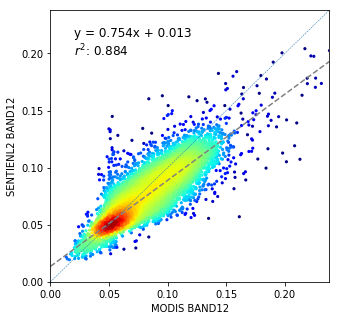

In [62]:
fig = plt.figure(figsize=(5,5))
s_b12 = b12_conved[H_inds[0], H_inds[1]]
x,y = m_b12[~s_b12.mask], s_b12[~s_b12.mask]*0.0001
ax = fig.add_subplot(1,1,1)
cmap = plt.cm.jet
mval = np.nanmax([x,y])
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)
slope,inter, rval, pval, std = scipy.stats.linregress(x, y)
if inter<0:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' - %.03f \n'%(-inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
else:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)

ax.scatter(x,y, c=kde, marker='o', s=10, edgecolor='',\
       norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
ax.set_xlim(0, mval)
ax.set_ylim(0, mval)
plt.xlabel('MODIS BAND12')
plt.ylabel('SENTIENL2 BAND12')

Compared to the previous regression image, we can see that it has improved a lot, so the PSF model is neccessary for the connection between different scale image. We also optimize the shifts on x and y direction.

In [69]:
cost_map = []
for i in np.arange(-50,51):
    for j in np.arange(-50,51):
        x_ind, y_ind = H_inds[0]+int(i), H_inds[1]+int(j)
        ma_ = (x_ind>0)&(x_ind<10980)&(y_ind>0)&(y_ind<10980)&(qa[-1]<1) # in tile and with qa=0
        b12_sub = b12_conved[x_ind[ma_], y_ind[ma_]]
        lin = linregress(m_b12[ma_][~b12_sub.mask], b12_sub[~b12_sub.mask]*0.0001)
        cos = lin.rvalue
        cost_map.append(lin.rvalue)

In [73]:
np.arange(-50,51)

array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
       -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
       -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
       -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50])

[28 37] [28 37]


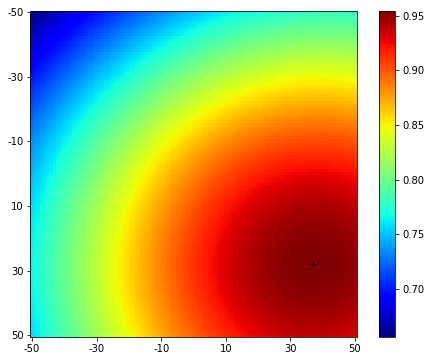

In [115]:
plt.figure(figsize=(8,6))
cost_map = np.array(cost_map).reshape(101, 101)
plt.imshow(cost_map, interpolation='Nearest', cmap=plt.cm.jet)
plt.xticks(np.arange(0, 101, 20), np.arange(-50, 51, 20))
plt.yticks(np.arange(0, 101, 20), np.arange(-50, 51, 20))
x0, y0 = np.where(cost_map==cost_map.max())
plt.colorbar()
plt.plot(y0[0], x0[0], 'k+')
print np.arange(-50,51, 1)[[x0[0], y0[0]], ], np.arange(-50,51, 1)[[x0[0], y0[0]], ]

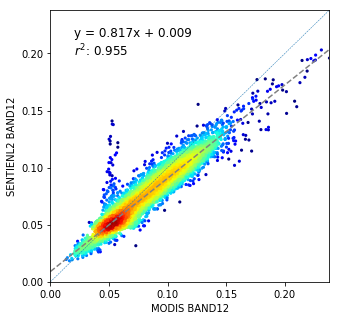

In [117]:
i,j = 28, 37
x_ind, y_ind = H_inds[0]+int(i), H_inds[1]+int(j)
ma_ = (x_ind>0)&(x_ind<10980)&(y_ind>0)&(y_ind<10980)&(qa[-1]<1)
b12_sub = b12_conved[x_ind[ma_], y_ind[ma_]]
x, y = m_b12[ma][~b12_sub.mask], b12_sub[~b12_sub.mask]*0.0001
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
mval = np.nanmax([x,y])
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)
slope,inter, rval, pval, std = scipy.stats.linregress(x, y)
if inter<0:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' - %.03f \n'%(-inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
else:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)

ax.scatter(x,y, c=kde, marker='o', s=10, edgecolor='',\
       norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = plt.cm.jet,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
ax.set_xlim(0, mval)
ax.set_ylim(0, mval)
plt.xlabel('MODIS BAND12')
plt.ylabel('SENTIENL2 BAND12')

(0, 0.23809723991525608)

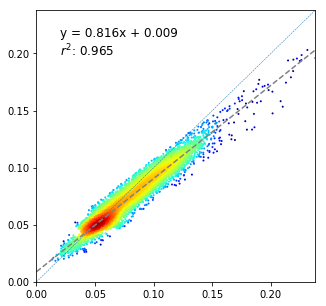

In [118]:
# using ransac to get rid of some outliers
cmap = plt.cm.jet
mval = np.nanmax([x,y])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
m_b12_in, s_b12_in, in_mask = ransaclin(x,y, residual_threshold=0.02)
xy = np.vstack([m_b12_in.ravel(), s_b12_in.ravel()])
kde = gaussian_kde(xy)(xy)
ax.scatter(m_b12_in, s_b12_in, c=kde, s=4, edgecolor='',\
           norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(m_b12_in.ravel(), s_b12_in.ravel(),1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
slope,inter, rval, pval, std = scipy.stats.linregress(m_b12_in.ravel(), s_b12_in.ravel())
ax.text(mval*(.5/6.),mval*(5./6.),\
        'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
plt.xlim(0,mval)
plt.ylim(0,mval)

#### Spectral mapping

Since the MODIS and Sentinel 2 share very similar spectral bands, so we use the linear regression between the closest bands to map between different them.

In [6]:
import scipy.io
from read_rsr import read_rsr
spectra_fn = '/home/ucfafyi/DATA/Multiply/spectral_mapping/spectrals/Spectres.sav'
spectra = scipy.io.readsav(spectra_fn)
int_spec = {}
#m = len(spectra.spectres)
rsr =  '/home/ucfafyi/DATA/Multiply/spectral_mapping/RSRs/sentinel2_RSR.txt',\
'/home/ucfafyi/DATA/Multiply/spectral_mapping/RSRs/aqua_RSR.txt'
for i in rsr:
    sensor = read_rsr(i)
    name = i.split('_RSR')[0].split('/')[-1]
    int_spec[name] = get_int_refs(sensor, swl=spectra.wl, specs = spectra.spectres)

In [7]:
sen_spec = np.array(int_spec['sentinel2']['cwls'])[[1,2,3,7,11,12,8],],np.array(int_spec['sentinel2']['bands'])[[1,2,3,7,11,12,8],], int_spec['sentinel2']['int_refs'][[1,2,3,7,11,12,8],]

In [8]:
mod_spec = np.array(int_spec['aqua']['cwls'])[[2,3,0,1,5,6,1],],np.array(int_spec['aqua']['bands'])[[2,3,0,1,5,6,1],], int_spec['aqua']['int_refs'][[2,3,0,1,5,6,1],]

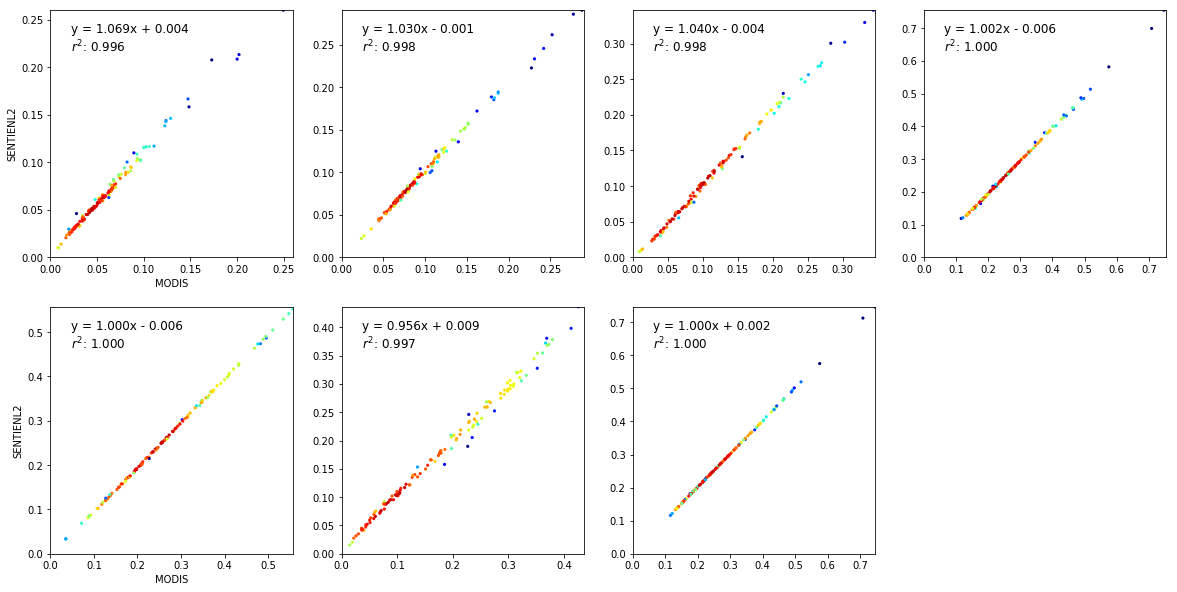

In [11]:
fig = plt.figure(figsize=(20,10))
from scipy.stats import gaussian_kde
mod_sen_reg = []
for i, j in enumerate(sen_spec[2]):
    ax = fig.add_subplot(2,4,i+1)
    x, y = mod_spec[2][i], sen_spec[2][i]
    mval = np.nanmax([x,y])
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)(xy)
    slope,inter, rval, pval, std = scipy.stats.linregress(x, y)
    if inter<0:
        ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' - %.03f \n'%(-inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
    else:
        ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
    
    ax.scatter(x,y, c=kde, marker='o', s=10, edgecolor='',\
           norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = plt.cm.jet,rasterized=True)
    ax.set_xlim(0, mval)
    ax.set_ylim(0, mval)
    mod_sen_reg.append([[mod_spec[0][i],mod_spec[1][i]],[sen_spec[0][i],sen_spec[1][i]], [slope,inter]])
    if (i==0) or (i==4):
        ax.set_xlabel('MODIS')
        ax.set_ylabel('SENTIENL2')
        

In [23]:
slops, offs = np.array(mod_sen_reg)[:,2] .T

In [27]:
slops.astype(float) , offs.astype(float)

(array([ 1.06946607,  1.03048916,  1.04039226,  1.00163932,  1.00010918,
         0.95607606,  0.99951677]),
 array([ 0.0035921 , -0.00142761, -0.00383504, -0.00558762, -0.00570695,
         0.00861192,  0.00188871]))

Now we combine the spatial and spectral mapping together.

(0, 0.23809723991525608)

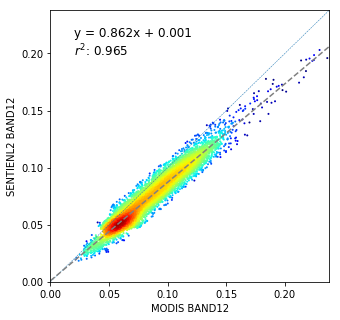

In [127]:
i,j = 28, 37
x_ind, y_ind = H_inds[0]+int(i), H_inds[1]+int(j)
mas = (x_ind>0)&(x_ind<10980)&(y_ind>0)&(y_ind<10980)&(qa[-1]<1)
b12_sub = b12_conved[x_ind[mas], y_ind[mas]]
m_fed, s_fed = m_b12[mas][~b12_sub.mask], b12_sub[~b12_sub.mask]*0.0001
cmap = plt.cm.jet
mval = np.nanmax([m_fed, s_fed])
slop, off = mod_sen_reg[6][-1]
m_fed = slop*m_fed+off # apply the spectral regression
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
m_b12_in, s_b12_in, in_mask = ransaclin(m_fed, s_fed, residual_threshold=0.02)
xy = np.vstack([m_b12_in.ravel(), s_b12_in.ravel()])
kde = gaussian_kde(xy)(xy)
ax.scatter(m_b12_in, s_b12_in, c=kde, s=4, edgecolor='',\
           norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(m_b12_in.ravel(), s_b12_in.ravel(),1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
slope,inter, rval, pval, std = scipy.stats.linregress(m_b12_in.ravel(), s_b12_in.ravel())
ax.text(mval*(.5/6.),mval*(5./6.),\
        'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
ax.set_xlabel('MODIS BAND12')
ax.set_ylabel('SENTIENL2 BAND12')
plt.xlim(0,mval)
plt.ylim(0,mval)

Now we see that the offset has decreased and the slop is closer to 1, as we use the spectral regresson results between them.

So we should be able to optimize the psf as well to get a better fitting between them.

In [128]:
pa = 5000, 1500, 10980-5000, 10980-5000 # we implement patch as well
bands = 'B02', 'B03', 'B04', 'B08', 'B11', 'B12', 'B8A'
fnames = [s2_dir+band_str+'.jp2' for band_str in bands]
pool = multiprocessing.Pool(processes=len(bands))
ret = pool.map(partial(gdal_read, patch=pa), fnames)
img = dict(zip(bands,ret))

In [17]:
pa = 5000, 1500, 10980-5000, 10980-5000 
b12 = ScaleExtent(img['B12'], (10980, 10980))
xstd, ystd = 29.75, 39
ker = gaussian(xstd, ystd, 0)
conved = signal.fftconvolve(b12, ker, mode='same')
size = 2*int(round(max(1.96*xstd, 1.96*ystd)))
b12[0,:]=b12[-1,:]=b12[:,0]=b12[:,-1]=0
dila_cloud = cloud_dilation( b12 == 0, iteration=size/2) 

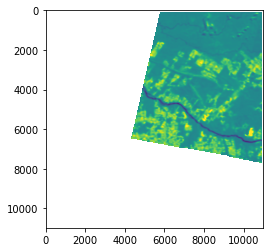

In [18]:
# a patch after correction
plt.imshow(ma.array(conved*0.0001, mask=dila_cloud), interpolation='None', vmin=0, vmax=0.3)

In [134]:
inpa_m = (H_inds[0]>pa[1])&(H_inds[0]<(pa[1]+pa[3]))&(H_inds[1]>pa[0])&(H_inds[1]<(pa[0]+pa[2]))
pa_mod = m_b12[inpa_m]
pa_qa = qa[6][inpa_m]
pa_hind = H_inds[0,inpa_m]-pa[1], H_inds[1,inpa_m]-pa[0]
cost=0
xs_, ys_ = 0,0
slop, off = mod_sen_reg[6][-1]
for xs in range(-50,50):
    for ys in range(-50,50):
        x_ind, y_ind = pa_hind[0]+xs, pa_hind[1]+ys
        intile_m = (x_ind>0)&(x_ind<pa[3])&(y_ind>0)&(y_ind<pa[2])
        paqa_m = pa_qa[6]<1
        mask = intile_m & paqa_m
        b12_masked = ma.array(conved, mask=dila_cloud)
        sb12, mb12 = b12_masked[x_ind[mask], y_ind[mask]], pa_mod[mask]
        the_mask = mb12.mask|sb12.mask
        m_fed, s_fed = slop*mb12[~the_mask]+off, sb12[~the_mask]*0.0001
        lin = linregress(m_fed, s_fed)
        cos = lin.rvalue
        if cos>cost:
            xs_, ys_ , cost= xs,ys,cos     

In [135]:
xs_, ys_ , cost

(27, 37, 0.96099573246820835)

In [137]:
inpa_m = (H_inds[0]>pa[1])&(H_inds[0]<(pa[1]+pa[3]))&(H_inds[1]>pa[0])&(H_inds[1]<(pa[0]+pa[2]))
pa_mod = m_b12[inpa_m]
pa_qa = qa[6][inpa_m]
pa_hind = H_inds[0,inpa_m]-pa[1], H_inds[1,inpa_m]-pa[0]
cost=0
xs, ys = xs_, ys_
x_ind, y_ind = pa_hind[0]+xs, pa_hind[1]+ys
intile_m = (x_ind>0)&(x_ind<pa[3])&(y_ind>0)&(y_ind<pa[2])
paqa_m = pa_qa[6]<1
mask = intile_m & paqa_m
b12_masked = ma.array(conved, mask=dila_cloud)
sb12, mb12 = b12_masked[x_ind[mask], y_ind[mask]], pa_mod[mask]
the_mask = mb12.mask|sb12.mask
x, y = slop*mb12[~the_mask]+off, sb12[~the_mask]*0.0001

(0, 0.23809723991525608)

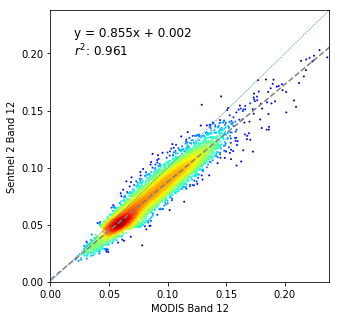

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)
ax.scatter(m_fed, s_fed, c=kde, s=4, edgecolor='',\
           norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(m_fed, s_fed,1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
slope,inter, rval, pval, std = scipy.stats.linregress(m_fed, s_fed)
ax.text(mval*(.5/6.),mval*(5./6.),\
        'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
plt.xlabel('MODIS Band 12')
plt.ylabel('Sentnel 2 Band 12')
plt.xlim(0,mval)
plt.ylim(0,mval)

In [173]:
def cost(p,args = None):
    ba, cloud, H_inds, L_inds, m_b, qa_b, pa, xs_, ys_, slop, off = args
    xstd, ystd, ang  = p
    ker = gaussian(xstd, ystd, ang)
    conved = signal.fftconvolve(b12, ker, mode='same')
    size = 2*int(round(max(1.96*xstd, 1.96*ystd)))
    ba[0,:]=ba[-1,:]=ba[:,0]=ba[:,-1]=0
    dila_cloud = cloud_dilation( (ba == 0) | cloud, iteration=size/2)
    
    inpa_m = (H_inds[0]>pa[1])&(H_inds[0]<(pa[1]+pa[3]))&(H_inds[1]>pa[0])&(H_inds[1]<(pa[0]+pa[2]))
    pa_mod = m_b[inpa_m]
    pa_qa = qa_b[inpa_m]
    pa_hind = H_inds[0,inpa_m]-pa[1], H_inds[1,inpa_m]-pa[0]
    xs, ys = xs_, ys_
    x_ind, y_ind = pa_hind[0]+xs, pa_hind[1]+ys
    intile_m = (x_ind>0)&(x_ind<pa[3])&(y_ind>0)&(y_ind<pa[2])
    paqa_m = pa_qa[6]<1
    mask = intile_m & paqa_m
    b_masked = ma.array(conved, mask=dila_cloud)
    sb, mb = b_masked[x_ind[mask], y_ind[mask]], pa_mod[mask]
    the_mask = mb.mask|sb.mask
    m_fed, s_fed = slop*mb[~the_mask]+off, sb[~the_mask]*0.0001
    if np.all(the_mask)==True:
        return 10000
    else:
        lin = linregress(m_fed, s_fed)
        return abs(1-lin.rvalue)

In [144]:
from scipy import optimize
p0=(29.75, 39, 5)
args =(b12,False, H_inds, L_inds, m_b12, qa[6],pa, xs_, ys_, slop, off)
#retval = optimize.fmin(cost, p0, full_output=1, maxiter=1000, maxfun=1500, )
#optimize.minimize(cost, p0, args = (args,), method='L-BFGS-B', tol=0.0001, )

      fun: 0.037418728506920962
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.23154828e-05,   5.51669821e-05,   1.63646874e-05])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([ 29.75,  41.  ,   0.  ])

In [145]:
ba, cloud, H_inds, L_inds, m_b, qa_b, pa, xs_, ys_, slop, off = args
xstd, ystd, ang  = 29.75, 39, 5
ker = gaussian(xstd, ystd, ang)
conved = signal.fftconvolve(b12, ker, mode='same')
size = 2*int(round(max(1.96*xstd, 1.96*ystd)))
ba[0,:]=ba[-1,:]=ba[:,0]=ba[:,-1]=0
dila_cloud = cloud_dilation( (ba == 0) | cloud, iteration=size/2)

inpa_m = (H_inds[0]>pa[1])&(H_inds[0]<(pa[1]+pa[3]))&(H_inds[1]>pa[0])&(H_inds[1]<(pa[0]+pa[2]))
pa_mod = m_b[inpa_m]
pa_qa = qa_b[inpa_m]
pa_hind = H_inds[0,inpa_m]-pa[1], H_inds[1,inpa_m]-pa[0]
xs, ys = xs_, ys_
x_ind, y_ind = pa_hind[0]+xs, pa_hind[1]+ys
intile_m = (x_ind>0)&(x_ind<pa[3])&(y_ind>0)&(y_ind<pa[2])
paqa_m = pa_qa[6]<1
mask = intile_m & paqa_m
b_masked = ma.array(conved, mask=dila_cloud)
sb, mb = b_masked[x_ind[mask], y_ind[mask]], pa_mod[mask]
the_mask = mb.mask|sb.mask
m_fed, s_fed = slop*mb[~the_mask]+off, sb[~the_mask]*0.0001
lin = linregress(m_fed, s_fed)

(0, 0.23809723991525608)

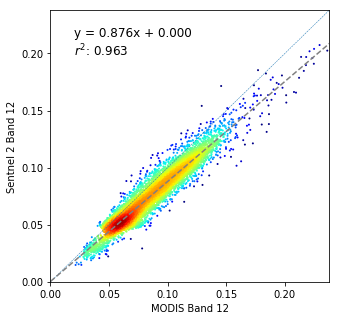

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
xy = np.vstack([m_fed, s_fed])
kde = gaussian_kde(xy)(xy)
ax.scatter(m_fed, s_fed, c=kde, s=4, edgecolor='',\
           norm=colors.LogNorm(vmin=kde.min(), vmax=kde.max()*1.2), cmap = cmap,rasterized=True)
ax.plot([0,1],[0.,1], '--',linewidth=0.5)
fit = np.polyfit(m_fed, s_fed,1)
fit_fn = np.poly1d(fit)
ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
slope,inter, rval, pval, std = scipy.stats.linregress(m_fed, s_fed)
if inter<0:
        ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' - %.03f \n'%(-inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
else:
    ax.text(mval*(.5/6.),mval*(5./6.),'y = %.03f'%(slope)+r"x" + ' + %.03f \n'%(inter)+ r"${r^2}$"+': %.03f' %(rval), fontsize=12)
plt.xlabel('MODIS Band 12')
plt.ylabel('Sentnel 2 Band 12')
plt.xlim(0,mval)
plt.ylim(0,mval)

We can see for this area, the change is not that big when we change the window size from 40 to 30 in x directtion, and this maybe due to the surface dose not change that much and the shape and window size dose not really affect the results that much.

So now we can wrap them up as an class for the later usage.

In [12]:
s2_files = np.loadtxt('data/s2_files.txt', dtype=str)
root = '/home/ucfafyi/DATA/S2_MODIS/'
m_dir = root + 'm_data/'
for site, lat, lon, s2_dir in s2_files[1:2]:
    date = '-'.join(s2_dir.split('/')[-5:-2])
    h,v = mtile_cal(float(lat), float(lon))
    y_m_d = datetime.strptime(date, '%Y-%m-%d')
    doy = y_m_d.timetuple().tm_yday
    m_file = glob(m_dir+'MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(y_m_d.year, doy,h,v))
    print site, (float(lat), float(lon)), (date, s2_dir), (h, v, doy,  m_file[0])

Alta_Floresta (-9.871339, -56.104453) ('2016-5-2', '/home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/') (12, 9, 123, '/home/ucfafyi/DATA/S2_MODIS/m_data/MCD43A1.A2016123.h12v09.006.2016181190917.hdf')


In [13]:
s2_fname = s2_dir+'B04.jp2'
tiles = Find_corresponding_pixels(s2_fname, destination_res=500)
print 'There are %d MODIS tiles covered by this high resolution image.'%len(tiles), '\n', 'Thay are %s and %s'%(tiles.keys()[0],tiles.keys()[1])

There are 2 MODIS tiles covered by this high resolution image. 
Thay are h12v09 and h12v10


In [64]:
%%time
filename = s2_dir+'B12.jp2'+'.memmap'
fp = np.memmap(filename, dtype='float32', mode='w+', shape=b12.shape)
fp[:] = b12[:]

CPU times: user 22 ms, sys: 61 ms, total: 83 ms
Wall time: 1.09 s


In [60]:
%%time
g = gdal.Open(s2_dir+'B12.jp2')
b12 = np.memmap(filename, dtype='float32', mode='c', shape=(g.RasterXSize, g.RasterYSize))

CPU times: user 2 ms, sys: 4 ms, total: 6 ms
Wall time: 6.04 ms


Using the numpy memmap it drastically increases the spead.

In [87]:
# define a function for the read in of jp2 file and create memmap file
def gdal_read(fname, patch = None, creat_memmap=False):
    '''
    a function for the reading of sentinel 2 files
    if the image is not 10980 * 10980
    then the patch will be shrink with
    correpsonding propotion, i.e. 2,6 
    for 20 meters and 60 meters resolution
    '''
    g = gdal.Open(fname)
    if g is None:
        raise IOError
    else:
        shape = (g.RasterXSize,g.RasterYSize)
        
        # create memap or not
        if creat_memmap:
            fp = np.memmap(fname+'.memmap', dtype='float32', mode='w+', shape=shape)
        else:
            fp=np.empty(shape=shape)
        if patch == None:
            data = g.ReadAsArray()
            fp[:] = data[:]
            return data
        else:
            if  shape == (5490, 5490):
                xoff, yoff, xsize, ysize = np.array(patch)/2
                data = g.ReadAsArray(xoff, yoff, xsize, ysize)
                fp[:] = data[:]
                return data
 
            if  shape  == (1830, 1830):
                xoff, yoff, xsize, ysize = np.array(patch)/6
                data = g.ReadAsArray(xoff, yoff, xsize, ysize)
                fp[:] = data[:]
                return data
            else:
                xoff, yoff, xsize, ysize = patch
                data = g.ReadAsArray(xoff, yoff, xsize, ysize)
                fp[:] = data[:]
                return data

Another better way to do it is using gdalbuildvrt to create virtual file and open it.

In [2]:
!gdalinfo /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/10meter.vrt

Driver: VRT/Virtual Raster
Files: /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/10meter.vrt
       /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/B02.jp2
       /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/B03.jp2
       /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/B04.jp2
       /home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/B08.jp2
Size is 10980, 10980
Coordinate System is:
PROJCS["WGS 84 / UTM zone 21S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AXIS["Latitude",NORTH],
        AXIS["Longitude",EAST],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-57],
 

In [7]:
%%time
import gdal
s2_dir = '/home/ucfafyi/DATA/S2_MODIS/s_data/21/L/WK/2016/5/2/0/'
g = gdal.Open(s2_dir+'10meter.vrt')
data= g.GetVirtualMemArray()
b2,b3,b4,b8 = data
g1 = gdal.Open(s2_dir+'20meter.vrt')
data1 = g1.GetVirtualMemArray()
b8a, b11, b12 = data1[-3:,:,:]
bands = 'B02', 'B03', 'B04', 'B08', 'B11', 'B12', 'B8A'
img = dict(zip(bands, [b2,b3,b4,b8, b8a, b11, b12]))

CPU times: user 1e+03 µs, sys: 3 ms, total: 4 ms
Wall time: 7.15 ms
